In [1]:
%matplotlib inline
import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, seaborn as sns, json, time, csv, datetime as dt
import pickle, collections, random, math, numbers, scipy.sparse as sp, matplotlib.pyplot as plt, scipy.sparse as sp

def reload(mName):
    import importlib
    if mName in sys.modules:
        del sys.modules[mName]
    return importlib.import_module(mName)


from collections import deque, defaultdict, OrderedDict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, minmax_scale
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# classpath
ctx = os.path.abspath('..')
cps = [ctx]
_ = [sys.path.insert(0, cp) for cp in cps if cp not in sys.path]

# data path
datapath = '/'.join([ctx, 'data'])

seed = 88
utils = reload('utils.utils')
np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.random.seed(seed)

D:\Python\Anaconda3\envs\py3_5\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
scaler = MinMaxScaler()
scaler.partial_fit(np.array([1, 2, 3])[:, np.newaxis]).partial_fit(np.array([4, 5])[:, np.newaxis])
scaler.transform(np.array([1, 5])[:, np.newaxis])

D:\Python\Anaconda3\envs\py3_5\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[0.],
       [1.]])

## Test

In [ ]:
headers = ['user_id', 'query_movie_ids', 'genres', 'avg_rating', 'year', 'candidate_movie_id', 'rating']
teProcessed = pd.read_csv('./te_processed.csv', names=headers)
# teProcessed['query_movie_ids'] = teProcessed.query_movie_ids.str.replace('\[(.+)\]', '\\1')
# teProcessed['genres'] = teProcessed.genres.str.replace('\[(.+)\]', '\\1')
teProcessed.head() # .to_csv('./te_processed.csv', index=False, header=None)

### Shema

In [ ]:
# set([batch[batch.composer.str.contains('\|', na=False)].iloc[0].lyricist])
mapper = utils.PartialMapper(10000, keep_order=False).partial_fit()
mapper.inverse_transform(mapper.transform(batch.lyricist))[:10]
mapper.enc

# tf.decode_csv + tf.data.TextLineDataset

## Simple Data Preprocess

In [2]:
import datetime as dt

ratings = pd.read_csv("{}/ml-latest-small/ratings.csv".format(datapath))
ratings['timestamp'] = ratings.timestamp.map(dt.datetime.fromtimestamp).map(str)
ratings['ori_rating'] = ratings['rating']
ratings['rating'] = (ratings.rating >= 4).astype(int)
tr, te = utils.split_ratings(ratings)

movies = pd.read_csv("{}/ml-latest-small/movies.csv".format(datapath))
avg_rt = ratings.groupby("movieId", as_index=False).ori_rating.mean().rename(index=str, columns={'ori_rating': 'avg_rating'})
movies = movies.merge(avg_rt, how='left', on='movieId')
# movies.avg_rating.fillna(ratings.rating.mean())
movies["year"] = movies.title.str.findall("\(\s*(\d+)\s*\)").map(lambda lst: int(lst[-1]) if len(lst) else None)
# movies["year"] = minmax_scale(movies.year.fillna(movies.year.median()))

In [3]:
def preprocess(data, movie_trans, train_hist=None, is_train=True):
    queue = []
    data = data.merge(movie_trans, how="left", on="movieId")
    columns=["user_id", "query_movie_ids",
             "genres", "avg_rating", "year", "candidate_movie_id",
             "timestamp",
             "rating"]
    
    list2str = lambda lst: ','.join(map(str, lst))
    for u, df in data.groupby("userId"):
        df = df.sort_values("rating", ascending=False)
        if not is_train:
            user_movies_hist = train_hist.query("userId == {}".format(u)).movieId
        for i, (_, r) in enumerate(df.iterrows()):
            if is_train:
                query_hist = df.movieId[:i].tolist() + df.movieId[i + 1:].tolist()
                query_hist = list2str(query_hist)
                queue.append([int(r.userId), query_hist, r.genres, r.avg_rating, r.year, int(r.movieId), r.timestamp, r.rating])
            else:
                all_hist = set(user_movies_hist.tolist())
                query_hist = list(all_hist - set([int(r.movieId)]))
                query_hist = list2str(query_hist)
                queue.append([int(r.userId), query_hist, r.genres, r.avg_rating, r.year, int(r.movieId), r.timestamp, r.rating])
    return pd.DataFrame(queue, columns=columns)
    
tr_merged = preprocess(tr, movies)
tr_merged.to_csv('./tr_movielens.csv', index=False, header=None)

te_merged = preprocess(te, movies, tr, is_train=False)
te_merged.to_csv('./te_movielens.csv', index=False, header=None)
te_merged.head()
# 合併成一個檔案
merged = pd.concat([tr_merged, te_merged], ignore_index=True)
merged.to_csv('./merged_movielens.csv', index=False, header=None)
merged.head()

,user_id,query_movie_ids,genres,avg_rating,year,candidate_movie_id,timestamp,rating
0,1,"1953,2105,31,1029,1061,1129,1263,1287,1293,133...",Drama,4.260870,1989.0,1172,2009-12-14 10:53:25,1
1,1,"1172,2105,31,1029,1061,1129,1263,1287,1293,133...",Action|Crime|Thriller,4.021739,1971.0,1953,2009-12-14 10:53:11,1
2,1,"1172,1953,31,1029,1061,1129,1263,1287,1293,133...",Action|Adventure|Sci-Fi,3.478723,1982.0,2105,2009-12-14 10:52:19,1
3,1,"1172,1953,2105,1029,1061,1129,1263,1287,1293,1...",Drama,3.178571,1995.0,31,2009-12-14 10:52:24,0
4,1,"1172,1953,2105,31,1061,1129,1263,1287,1293,133...",Animation|Children|Drama|Musical,3.702381,1941.0,1029,2009-12-14 10:52:59,0


In [4]:
utils = reload('utils.utils')
mapper = utils.PartialMapper(padding_null=True).partial_fit( merged.head().candidate_movie_id )
mapper.classes_

[None, 1953, 1172, 1029, 2105, 31]

numpy.float64

## Write Config File

In [414]:
# self.conf = OrderedDict(
#     user = [{Schema.ID: 'query_movie_ids', Schema.DTYPE: 'str', Schema.MODEL_DTYPE: 'catg',
#              Schema.N_UNIQUE: 9125, Schema.IS_MULTI: True, Schema.SEP: ','}],
#     item = [{Schema.ID: 'genres', Schema.DTYPE: 'str', Schema.MODEL_DTYPE: 'catg', Schema.N_UNIQUE: 20, Schema.IS_MULTI: True, Schema.SEP: ','},
#             {Schema.ID: 'avg_rating', Schema.DTYPE: 'float', Schema.MODEL_DTYPE: 'cont'},
#             {Schema.ID: 'year', Schema.DTYPE: 'float', Schema.MODEL_DTYPE: 'cont'},
#             {Schema.ID: 'candidate_movie_id', Schema.TYPE: 'catg', Schema.N_UNIQUE: 9125}],
#     label = [{Schema.ID: 'rating', Schema.MODEL_DTYPE: 'catg'}]
# )
utils = reload('utils.utils')
reco = reload('reco_mf_dnn.reco_mf_dnn_flex_shema')
json_conf = '''
{
    "columns": [{"id": "user_id", "m_dtype": "catg"},
                {"id": "query_movie_ids", "m_dtype": "catg", "is_multi": true, "n_unique": 9125, "sep": ","},
                {"id": "genres", "m_dtype": "catg", "is_multi": true, "sep": "|", "n_unique": 20},
                {"id": "avg_rating", "m_dtype": "cont"},
                {"id": "year", "m_dtype": "cont"},
                {"id": "candidate_movie_id", "m_dtype": "catg", "n_unique": 9125},
                {"id": "timestamp", "m_dtype": "datetime", "date_format": "%Y-%m-%d %H:%M:%S"},
                {"id": "rating", "m_dtype": "catg", "n_unique": 2}],
    "label": ["rating"],
    "user": ["query_movie_ids", "timestamp"],
    "item": ["genres", "avg_rating", "year", "candidate_movie_id"]
}
'''.strip()
schema = reco.Schema(json_conf, ['./merged_movielens.csv'])
# schema.df_conf_
# schema.col_states['query_movie_ids'].to_json()

D:\Python\Anaconda3\envs\py3_5\lib\site-packages\pandas\core\strings.py:1036: FutureWarning: split() requires a non-empty pattern match.
  f = lambda x: regex.split(x, maxsplit=n)


In [415]:
schema.df_conf_

,id,date_format,m_dtype,n_unique,is_multi,sep,aux,type,col_state
0,user_id,,catg,0,False,,False,,
1,query_movie_ids,,catg,9125,True,",",False,user,"{""classes_"": [null, ""527"", ""52"", ""2028"", ""31"",..."
2,genres,,catg,20,True,|,False,item,"{""classes_"": [null, ""Drama|Romance|War|Western..."
3,avg_rating,,cont,0,False,,False,item,"{""min_"": 2.2051282051282053, ""cumsum_"": 360.27..."
4,year,,cont,0,False,,False,item,"{""min_"": 1941.0, ""cumsum_"": 199205.0, ""max_"": ..."
5,candidate_movie_id,,catg,9125,False,,False,item,"{""classes_"": [null, ""527"", ""52"", ""2028"", ""31"",..."
6,timestamp,%Y-%m-%d %H:%M:%S,datetime,0,False,,False,user,"{""min_"": 835355395.0, ""cumsum_"": 104787784765...."
7,rating,,catg,2,False,,False,label,"{""classes_"": [null, ""1"", ""0""]}"


In [426]:
lst = schema.df_conf_.to_dict('records')
for i, e in enumerate(lst, 1):
    print(e)
    if i >= 2: break

{'aux': False, 'type': '', 'm_dtype': 'catg', 'id': 'user_id', 'sep': '', 'n_unique': 0, 'is_multi': False, 'col_state': '', 'date_format': ''}
{'aux': False, 'type': 'user', 'm_dtype': 'catg', 'id': 'query_movie_ids', 'sep': ',', 'n_unique': 9125, 'is_multi': True, 'col_state': '{"classes_": [null, "527", "52", "2028", "31", "317", "1172", "2841", "186", "339", "592", "356", "165", "318", "47", "222", "349", "208", "265", "778", "1271", "1263", "273", "247", "593", "474", "1293", "468", "2513", "367", "1129", "377", "153", "10", "235", "168", "2694", "150", "1884", "371", "350", "410", "370", "357", "144", "2762", "267", "292", "2959", "372", "1378", "2105", "39", "261", "1405", "319", "1287", "2858", "1580", "253", "2318", "2716", "1029", "296", "595", "1343", "1371", "1061", "60", "588", "50", "161", "364", "355", "866", "1197", "1235", "382", "1210", "248", "185", "457", "272", "62", "266", "223", "300", "110", "480", "454", "405", "1953", "1339", "17", "736", "225", "314", "2702",

In [436]:
json.loads(schema.df_conf_.to_json(orient='records'))

[{'aux': False,
  'col_state': '',
  'date_format': '',
  'id': 'user_id',
  'is_multi': False,
  'm_dtype': 'catg',
  'n_unique': 0,
  'sep': '',
  'type': ''},
 {'aux': False,
  'col_state': '{"classes_": [null, "527", "52", "2028", "31", "317", "1172", "2841", "186", "339", "592", "356", "165", "318", "47", "222", "349", "208", "265", "778", "1271", "1263", "273", "247", "593", "474", "1293", "468", "2513", "367", "1129", "377", "153", "10", "235", "168", "2694", "150", "1884", "371", "350", "410", "370", "357", "144", "2762", "267", "292", "2959", "372", "1378", "2105", "39", "261", "1405", "319", "1287", "2858", "1580", "253", "2318", "2716", "1029", "296", "595", "1343", "1371", "1061", "60", "588", "50", "161", "364", "355", "866", "1197", "1235", "382", "1210", "248", "185", "457", "272", "62", "266", "223", "300", "110", "480", "454", "405", "1953", "1339", "17", "736", "225", "314", "2702", "1721"]}',
  'date_format': '',
  'id': 'query_movie_ids',
  'is_multi': True,
  'm_dt

In [231]:
utils = reload('utils.utils')
mapper = utils.NumericMapper()
mapper.partial_fit([0, 80, None])
print( mapper.mean )
mapper.transform([1, 2, 3]) # array([0.0125, 0.025 , 0.0375])

mapper.scaler.data_max_
# mapper = utils.CatgMapper(padding_null=True)
# mapper.partial_fit(['1', 'xxx', 'ooo'])
# mapper.inverse_transform(mapper.transform(['xxx', '1', None]))

40.0


array([80.])

In [127]:
from datetime import datetime
merged = pd.read_csv('./merged_movielens.csv', names=tr_merged.columns)
merged.head()

,user_id,query_movie_ids,genres,avg_rating,year,candidate_movie_id,timestamp,rating
0,1,"1953,2105,31,1029,1061,1129,1263,1287,1293,133...",Drama,4.260870,1989.0,1172,2009-12-14 10:53:25,1
1,1,"1172,2105,31,1029,1061,1129,1263,1287,1293,133...",Action|Crime|Thriller,4.021739,1971.0,1953,2009-12-14 10:53:11,1
2,1,"1172,1953,31,1029,1061,1129,1263,1287,1293,133...",Action|Adventure|Sci-Fi,3.478723,1982.0,2105,2009-12-14 10:52:19,1
3,1,"1172,1953,2105,1029,1061,1129,1263,1287,1293,1...",Drama,3.178571,1995.0,31,2009-12-14 10:52:24,0
4,1,"1172,1953,2105,31,1061,1129,1263,1287,1293,133...",Animation|Children|Drama|Musical,3.702381,1941.0,1029,2009-12-14 10:52:59,0


In [ ]:
%%time
def make_datasets(fpath_ary):
    cols = ['user_id', 'query_movie_ids', 'genres', 'avg_rating', 'year', 'candidate_movie_id', 'rating']
    defaults = [[0], [''], [''], [], [], [0], []]

    def to_dense(sp):
        dense = tf.sparse_to_dense(sp.indices, sp.dense_shape, sp.values, '')
        return tf.reshape(tf.to_int32(tf.string_to_number(dense)), [-1])

    def to_sparse(dense):
        idx = tf.where(tf.not_equal(dense, 0))
        return tf.SparseTensor(indices=idx, dense_shape=dense.get_shape(), values=tf.gather_nd(dense, idx))

    def parse_csv(value):
        data = tf.decode_csv(value, record_defaults=defaults)
        features = OrderedDict(zip(cols, data))
        for col in ('query_movie_ids', 'genres'):
            features[col] = tf.string_split([features[col]], ',')
            features[col] = to_sparse(to_dense(features[col]))
        return features 

    dataset = tf.data.TextLineDataset(fpath_ary)
    dataset = (dataset.map(parse_csv, num_parallel_calls=4)
                      .padded_batch(3, OrderedDict(zip(cols, ([], [None], [None], [], [], [], []))))
                      .shuffle(10, seed=seed)
                      .repeat(2)
              )
    return dataset.make_one_shot_iterator().get_next()

tf.reset_default_graph()
with tf.Graph().as_default():
    inputs = make_datasets(['./te_processed.batch.csv'])
    ctx = []
    with tf.train.MonitoredTrainingSession() as sess:
        while not sess.should_stop():
            print(sess.run(inputs)['user_id'])

## Feature Columns with tf.feature_column.input_layer

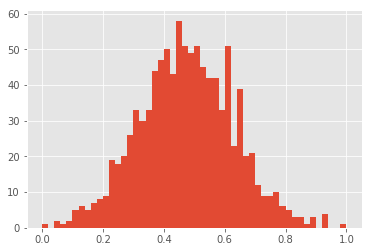

In [39]:
a = pd.Series(minmax_scale(np.random.normal(0, 1, size=1000)))
a.hist(bins=50)

In [ ]:
%%time
tf.reset_default_graph()
with tf.Graph().as_default():
    user_id = tf.feature_column.categorical_column_with_hash_bucket('user_id', hash_bucket_size=1000, dtype=tf.int32)
    user_id = tf.feature_column.embedding_column(user_id, dimension=8)
    avg_rating = tf.feature_column.numeric_column('avg_rating')
    columns = [user_id, avg_rating]
    
    def make_datasets(fpath_ary):
        cols = ['user_id', 'query_movie_ids', 'genres', 'avg_rating', 'year', 'candidate_movie_id', 'rating']
        defaults = [[0], [''], [''], [], [], [0], []]

        def parse_csv(value):
            data = tf.decode_csv(value, record_defaults=defaults)
            features = OrderedDict(zip(cols, data))
            # print(features)
            return features
        
        dataset = tf.data.TextLineDataset(fpath_ary)
        dataset = (dataset.map(parse_csv, num_parallel_calls=4)
                          .batch(3)
                          # .padded_batch(3, OrderedDict(zip(cols, ([], [None], [None], [], [], [], []))))
                          .shuffle(10, seed=seed)
                          .repeat(1)
                  )
        return dataset.make_one_shot_iterator().get_next()
    
    inputs = make_datasets(['./te_processed.batch.csv'])
    inputs = tf.feature_column.input_layer(inputs, columns)
    # features = tf.parse_example(serialized_example, features=tf.feature_column.make_parse_example_spec(columns))
    ctx = []
    with tf.train.MonitoredTrainingSession() as sess:
        while not sess.should_stop():
            print(sess.run(inputs))

### Make Example

In [ ]:
%%time
cols = ['user_id', 'query_movie_ids', 'genres', 'avg_rating', 'year', 'candidate_movie_id', 'rating']
is_multi = [False, True, True, False, False, False, False]
pd_dtypes = [int, str, str, float, float, int, float]
types = ['int64_list', 'int64_list', 'int64_list', 'float_list', 'float_list', 'int64_list', 'float_list']
tf_types = [tf.int64, tf.int64, tf.int64, tf.float32, tf.float32, tf.int64, tf.float32]
def persist_example(fpath, tfpath):
    with tf.python_io.TFRecordWriter(tfpath) as w:
        for chunk in pd.read_csv(fpath, names=cols, dtype=dict(zip(cols, pd_dtypes)), chunksize=1000):
            chunk['query_movie_ids'] = chunk.query_movie_ids.map(lambda r: map(int, r.split(',')))
            chunk['genres'] = chunk.genres.map(lambda r: map(int, r.split(',')))
            
            for idx, r in chunk.iterrows():
                ex = tf.train.Example()
                for multi, col, tpe in zip(is_multi, cols, types):
                    val = r[col]
                    # ex.features.feature[col].int64_list or float_list or bytes_list
                    feat_type = getattr(ex.features.feature[col], tpe)
                    # extend function for multivalent columns, otherwise append
                    append_or_extend = 'append' if not multi else 'extend'                    
                    getattr(feat_type.value, append_or_extend)(val)
                w.write(ex.SerializePartialToString())

persist_example('./te_processed.csv', './data.tfrecord')

In [ ]:
def decode_example(ser_example):
    # queue = tf.train.string_input_producer([fpath], num_epochs=1)
    # _, ser_example = tf.TFRecordReader().read(queue)
    # ser_example = tf.train.batch([ser_example], batch_size=10)
    ctx_features = {col: tf.FixedLenFeature([], tf_tpe)
                    for col, tf_tpe in zip(cols, tf_types) if col not in ('query_movie_ids', 'genres')}
    seq_features = {col: tf.FixedLenSequenceFeature([], tf_tpe) 
                    for col, tf_tpe in [('query_movie_ids', tf.int64), ('genres', tf.int64)]}
    context_dict, sequence_dict = tf.parse_single_sequence_example(ser_example, 
                                                                   context_features=ctx_features, 
                                                                   sequence_features=seq_features)
    # for col, tpe in zip(cols, tf_types):
    #     val = feature_dict[col]
    #     feature_dict[col] = tf.sparse_to_dense(val.indices, val.dense_shape, val.values, name=col)
    feature_dict = {}
    feature_dict.update(context_dict)
    feature_dict.update(sequence_dict)
    ret = OrderedDict()
    for c in cols:
        ret[c] = feature_dict[c]
    return tuple(ret.values())

tf.reset_default_graph()
with tf.Graph().as_default():
    dataset = tf.data.TFRecordDataset(['./data.tfrecord'])
    dataset = dataset.map(decode_example).padded_batch(10, padded_shapes=([], [None], [None], [], [], [], []))
    # dataset = dataset.batch(3)
    iters = dataset.make_one_shot_iterator()
    r = iters.get_next()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        print( sess.run(r) )

## Traditional parse_example
1. tf.train.Coordinator + tf.train.start_queue_runners

In [ ]:
from tensorflow.python.framework import sparse_tensor
import re

def to_sparse(dense):
    idx = tf.where(tf.not_equal(dense, 0))
    return tf.SparseTensor(idx, tf.gather_nd(dense, idx), dense.get_shape())

def make_example(val):
    example = tf.train.Example(features=tf.train.Features(
        feature = {
            'query_movie_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=val)),
            'genres': tf.train.Feature(int64_list=tf.train.Int64List(value=val))
        }
    ))
    return example

tf.reset_default_graph()
with tf.Graph().as_default():
    
    filename = "tmp.tfrecords"
    if not os.path.exists(filename):
        # os.remove(filename)
        writer = tf.python_io.TFRecordWriter(filename)
        with writer:
            for idx, r in teProcessed.head().iterrows():
                for col in ('query_movie_ids', 'genres'):
                    val = list(map(int, re.split(',\s*', r[col])))
                    ex = make_example(val)
                    writer.write(ex.SerializeToString())

    reader = tf.TFRecordReader()
    filename_queue = tf.train.string_input_producer(["tmp.tfrecords"], num_epochs=1)
    _, serialized_example = reader.read(filename_queue)

    batch = tf.train.batch(tensors=[serialized_example], batch_size=1)
    features = {
        'query_movie_ids': tf.VarLenFeature(tf.int64),
        'genres': tf.VarLenFeature(tf.int64)
    }
    data = tf.parse_example(batch, features)
    query_movie_ids = data['query_movie_ids']
    embbedding = tf.Variable(tf.glorot_uniform_initializer()([9125]), dtype=tf.float32)
    print(query_movie_ids.dense_shape)
    # r = tf.layers.dense(query_movie_ids, 10)
    # emb_query = tf.nn.embedding_lookup_sparse([embbedding], query_movie_ids, None, combiner='sqrtn')
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord, sess=sess)
        try:
            print(sess.run(data))
            pass
        except tf.errors.OutOfRangeError as e:
            coord.request_stop(e)
        finally:
            coord.request_stop()
            coord.join(threads)
    

## Test

In [ ]:
tf.reset_default_graph()
with tf.Graph().as_default():
    labels = tf.constant(np.ones([10, 8]))
    pred = tf.concat([tf.Variable(tf.ones(shape=[1, 8]), trainable=False), tf.Variable(tf.truncated_normal([9, 8]))], 0)
    loss = tf.losses.mean_squared_error(predictions=pred, labels=labels)
    train_op = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        print(pred.eval())
        for i in range(1000):
            sess.run([train_op])
        print()
        print(pred.eval())

In [ ]:
tf.zeros